In [1]:
import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PolynomialFeatures
import operator

In [2]:
filename = "2021-2022_NBA_Player_Stats.csv"
df = pd.read_csv(filename,index_col=0, encoding = "ISO-8859-1",  sep=';')
df.head(9)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Rk,,,,,,,,,,,,,,,,,,,,,
1,Precious Achiuwa,C,22,TOR,48,23,23.1,3.1,7.3,0.423,...,0.579,2.2,4.7,6.9,1.1,0.5,0.6,1.0,2.0,7.5
2,Steven Adams,C,28,MEM,56,55,26.1,2.8,5.0,0.546,...,0.556,4.5,5.1,9.6,3.2,0.9,0.7,1.6,1.9,7.0
3,Bam Adebayo,C,24,MIA,33,33,33.0,7.2,13.6,0.527,...,0.764,2.8,7.4,10.2,3.5,1.5,0.6,2.9,3.2,18.7
4,Santi Aldama,PF,21,MEM,27,0,10.3,1.4,3.6,0.381,...,0.600,0.9,1.5,2.4,0.5,0.1,0.3,0.3,1.0,3.3
5,LaMarcus Aldridge,C,36,BRK,38,11,22.8,5.8,10.5,0.558,...,0.844,1.6,4.2,5.8,0.8,0.3,1.1,1.0,1.7,13.7
6,Nickeil Alexander-Walker,SG,23,TOT,52,19,25.4,4.6,12.2,0.374,...,0.722,0.7,2.5,3.2,2.7,0.8,0.4,1.6,1.7,12.3
6,Nickeil Alexander-Walker,SG,23,NOP,50,19,26.3,4.7,12.6,0.375,...,0.722,0.7,2.6,3.3,2.8,0.8,0.4,1.7,1.8,12.8
6,Nickeil Alexander-Walker,SG,23,UTA,2,0,2.5,0.0,0.5,0.000,...,0.000,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0
7,Grayson Allen,SG,26,MIL,49,48,28.0,4.0,9.4,0.425,...,0.857,0.5,2.9,3.4,1.5,0.8,0.3,0.6,1.4,11.5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 734 entries, 1 to 592
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  734 non-null    object 
 1   Pos     734 non-null    object 
 2   Age     734 non-null    int64  
 3   Tm      734 non-null    object 
 4   G       734 non-null    int64  
 5   GS      734 non-null    int64  
 6   MP      734 non-null    float64
 7   FG      734 non-null    float64
 8   FGA     734 non-null    float64
 9   FG%     734 non-null    float64
 10  3P      734 non-null    float64
 11  3PA     734 non-null    float64
 12  3P%     734 non-null    float64
 13  2P      734 non-null    float64
 14  2PA     734 non-null    float64
 15  2P%     734 non-null    float64
 16  eFG%    734 non-null    float64
 17  FT      734 non-null    float64
 18  FTA     734 non-null    float64
 19  FT%     734 non-null    float64
 20  ORB     734 non-null    float64
 21  DRB     734 non-null    float64
 22  TR

In [4]:
df.describe()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,...,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,26.044959,28.279292,12.915531,18.114169,2.855586,6.401907,0.420251,0.868801,2.572071,0.274554,...,0.633832,0.810899,2.540736,3.349455,1.775749,0.576158,0.361717,0.979428,1.539782,7.727520
std,4.092637,19.514704,18.423425,9.995226,2.288435,4.781059,0.161695,0.879551,2.292469,0.175847,...,0.305932,0.760459,1.870797,2.438201,1.841861,0.447355,0.392693,0.834717,0.844562,6.265428
min,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,6.250000,0.000000,9.725000,1.100000,2.800000,0.375000,0.100000,0.700000,0.182000,...,0.563000,0.300000,1.225000,1.600000,0.500000,0.300000,0.100000,0.400000,1.000000,3.000000
50%,25.000000,31.000000,3.000000,17.000000,2.400000,5.100000,0.436000,0.600000,2.000000,0.320000,...,0.748000,0.600000,2.300000,2.950000,1.100000,0.500000,0.300000,0.800000,1.600000,6.300000
75%,29.000000,46.000000,20.000000,26.475000,4.000000,8.900000,0.497250,1.400000,3.900000,0.375000,...,0.833000,1.100000,3.400000,4.500000,2.300000,0.800000,0.500000,1.300000,2.200000,10.675000
max,41.000000,60.000000,60.000000,39.000000,11.000000,21.400000,1.000000,4.600000,12.300000,1.000000,...,1.000000,4.500000,11.300000,14.800000,11.000000,2.300000,3.000000,4.800000,4.000000,29.400000


In [5]:
df[df['G']<10]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Rk,,,,,,,,,,,,,,,,,,,,,
6,Nickeil Alexander-Walker,SG,23,UTA,2,0,2.5,0.0,0.5,0.000,...,0.000,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0
10,Justin Anderson,SF,28,TOT,6,0,12.8,1.0,3.2,0.316,...,0.857,0.3,1.3,1.7,1.5,0.3,0.2,0.5,1.5,3.5
10,Justin Anderson,SF,28,CLE,3,0,15.7,1.3,2.7,0.500,...,0.750,0.0,2.0,2.0,2.0,0.3,0.0,0.7,1.3,4.3
10,Justin Anderson,SF,28,IND,3,0,10.0,0.7,3.7,0.182,...,1.000,0.7,0.7,1.3,1.0,0.3,0.3,0.3,1.7,2.7
20,Joel Ayayi,SG,21,WAS,7,0,2.9,0.1,0.9,0.167,...,0.000,0.1,0.3,0.4,0.6,0.0,0.0,0.0,0.0,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,Justise Winslow,SF,25,POR,6,5,31.3,4.8,10.5,0.460,...,0.667,1.7,5.7,7.3,3.3,1.7,0.8,1.3,2.0,12.0
582,Cassius Winston,PG,23,WAS,4,0,5.8,0.8,1.5,0.500,...,1.000,0.0,0.0,0.0,1.0,0.0,0.0,0.3,1.0,2.5
586,McKinley Wright IV,PG,23,MIN,3,0,3.0,0.7,1.0,0.667,...,0.000,0.0,0.0,0.0,0.3,0.0,0.0,0.3,0.3,1.7


In [5]:
df.loc[df["Player"] == "Nikola Joki?", "Player"] = 'Nikola Jokic'
df.loc[df["Player"] == "Luka Don?i?", "Player"] = 'Luka Doncic'

In [6]:
all_star = [0]*734

In [7]:
df['ALLSTAR'] = all_star

In [8]:
df.loc[df['Player'].isin(['Trae Young', 'DeMar DeRozan', 'Joel Embiid', 'Kevin Durant', 'Giannis Antetokounmpo', 'LaMelo Ball', 
'Darius Garland', 'James Harden', 'Zach LaVine', 'Fred VanVleet', 'Jimmy Butler', 'Khris Middleton', 'Jayson Tatum', 'Jarrett Allen',
'Stephen Curry', 'Ja Morant', 'Nikola Jokic', 'LeBron James', 'Andrew Wiggins', 'Devin Booker', 'Luka Doncic', 'Donovan Mitchell', 
'Dejounte Murray', 'Chris Paul', 'Draymond Green', 'Rudy Gobert', 'Karl-Anthony Towns']), "ALLSTAR"] = 1

In [9]:
df[df['Player'].isin(['Trae Young', 'DeMar DeRozan', 'Joel Embiid', 'Kevin Durant', 'Giannis Antetokounmpo', 'LaMelo Ball', 
'Darius Garland', 'James Harden', 'Zach LaVine', 'Fred VanVleet', 'Jimmy Butler', 'Khris Middleton', 'Jayson Tatum', 'Jarrett Allen',
'Stephen Curry', 'Ja Morant', 'Nikola Jokic', 'LeBron James', 'Andrew Wiggins', 'Devin Booker', 'Luka Doncic', 'Donovan Mitchell', 
'Dejounte Murray', 'Chris Paul', 'Draymond Green', 'Rudy Gobert', 'Karl-Anthony Towns'])]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Rk,,,,,,,,,,,,,,,,,,,,,
8,Jarrett Allen,C,23,CLE,50,50,32.6,6.6,9.9,0.666,...,3.6,7.4,11.0,1.8,0.7,1.3,1.8,1.8,16.2,1
12,Giannis Antetokounmpo,PF,27,MIL,48,48,32.6,10.1,18.4,0.547,...,1.9,9.4,11.3,6.0,0.9,1.4,3.3,3.2,29.4,1
24,LaMelo Ball,PG,20,CHO,52,52,32.6,7.2,16.9,0.425,...,1.6,5.4,7.0,7.4,1.6,0.4,3.1,3.2,20.2,1
58,Devin Booker,SG,25,PHO,51,51,34.1,9.3,20.8,0.446,...,0.8,4.4,5.2,4.5,1.0,0.4,2.4,2.5,25.5,1
86,Jimmy Butler,SF,32,MIA,39,39,33.9,7.2,14.7,0.490,...,1.9,4.4,6.3,5.9,1.8,0.4,2.1,1.5,21.9,1
124,Stephen Curry,PG,33,GSW,54,54,34.8,8.4,19.6,0.427,...,0.6,4.7,5.3,6.3,1.4,0.4,3.2,2.1,25.8,1
132,DeMar DeRozan,PF,32,CHI,55,55,35.6,10.3,19.9,0.517,...,0.8,4.4,5.2,5.1,0.9,0.3,2.3,2.2,28.1,1
139,Luka Doncic,PG,22,DAL,43,43,35.4,9.6,21.3,0.448,...,0.9,8.2,9.0,9.0,1.2,0.5,4.4,2.4,27.0,1
151,Kevin Durant,PF,33,BRK,36,36,36.5,10.5,20.3,0.520,...,0.6,6.9,7.4,5.8,0.8,0.9,3.0,1.9,29.3,1


In [10]:
df[df['Player'].isin(['Klay Thompson'])]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Rk,,,,,,,,,,,,,,,,,,,,,
526,Klay Thompson,SG,31,GSW,16,16,25.3,6.2,14.8,0.418,...,0.4,3.4,3.8,3.1,0.6,0.4,1.4,1.5,17.1,0


In [11]:
dups=df.duplicated()
print(df[dups])

Empty DataFrame
Columns: [Player, Pos, Age, Tm, G, GS, MP, FG, FGA, FG%, 3P, 3PA, 3P%, 2P, 2PA, 2P%, eFG%, FT, FTA, FT%, ORB, DRB, TRB, AST, STL, BLK, TOV, PF, PTS, ALLSTAR]
Index: []

[0 rows x 30 columns]


In [12]:
tradedPlayers = df[df.duplicated(['Player'])]
print(tradedPlayers)

                       Player Pos  Age   Tm   G  GS    MP   FG   FGA    FG%  \
Rk                                                                            
6    Nickeil Alexander-Walker  SG   23  NOP  50  19  26.3  4.7  12.6  0.375   
6    Nickeil Alexander-Walker  SG   23  UTA   2   0   2.5  0.0   0.5  0.000   
10            Justin Anderson  SF   28  CLE   3   0  15.7  1.3   2.7  0.500   
10            Justin Anderson  SF   28  IND   3   0  10.0  0.7   3.7  0.182   
23          Marvin Bagley III  PF   22  SAC  30  17  21.9  3.8   8.2  0.463   
..                        ...  ..  ...  ...  ..  ..   ...  ...   ...    ...   
566             Derrick White  SG   27  BOS   4   1  30.3  4.3  11.3  0.378   
581           Justise Winslow  SF   25  LAC  37   1  12.9  1.7   3.8  0.447   
581           Justise Winslow  SF   25  POR   6   5  31.3  4.8  10.5  0.460   
588            Thaddeus Young  PF   33  SAS  26   1  14.2  2.8   4.9  0.578   
588            Thaddeus Young  PF   33  TOR   2   0 

In [13]:
print("Dataset obsahuje celkovo %d chýbajúcich hodnôt"%int(df.shape[0] - df.dropna().shape[0]))

Dataset obsahuje celkovo 0 chýbajúcich hodnôt


In [14]:
df.corr()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ALLSTAR
Age,1.000000,0.056058,0.073058,0.194370,0.140328,0.133415,0.087729,0.156460,0.137385,0.129006,...,0.067567,0.157399,0.142086,0.188638,0.108185,0.090543,0.118159,0.186133,0.142032,0.065101
G,0.056058,1.000000,0.665081,0.633563,0.552498,0.542508,0.291616,0.462582,0.455928,0.342202,...,0.299864,0.504509,0.480867,0.389125,0.433872,0.313493,0.443334,0.475367,0.554484,0.197619
GS,0.073058,0.665081,1.000000,0.764197,0.728904,0.715527,0.217586,0.521761,0.525951,0.200459,...,0.365049,0.649852,0.613295,0.580854,0.526683,0.401508,0.636659,0.547077,0.727546,0.372403
MP,0.194370,0.633563,0.764197,1.000000,0.890861,0.897971,0.306448,0.724485,0.735189,0.362068,...,0.366895,0.760373,0.697376,0.738968,0.705469,0.450094,0.756032,0.752087,0.892599,0.312108
FG,0.140328,0.552498,0.728904,0.890861,1.000000,0.969978,0.359642,0.689764,0.688423,0.323302,...,0.382519,0.750845,0.695048,0.733232,0.601840,0.410076,0.811571,0.651023,0.990747,0.458598
FGA,0.133415,0.542508,0.715527,0.897971,0.969978,1.000000,0.211101,0.769830,0.799473,0.324096,...,0.268793,0.686428,0.609714,0.763628,0.621276,0.338282,0.820246,0.610286,0.976309,0.431362
FG%,0.087729,0.291616,0.217586,0.306448,0.359642,0.211101,1.000000,0.083460,0.000791,0.277679,...,0.372324,0.367826,0.399661,0.127498,0.178006,0.342218,0.204144,0.404990,0.320946,0.089327
3P,0.156460,0.462582,0.521761,0.724485,0.689764,0.769830,0.083460,1.000000,0.967172,0.496118,...,-0.083790,0.362586,0.251558,0.553206,0.471315,0.110649,0.548766,0.404815,0.737822,0.253152
3PA,0.137385,0.455928,0.525951,0.735189,0.688423,0.799473,0.000791,0.967172,1.000000,0.402774,...,-0.107466,0.371459,0.250454,0.584658,0.500623,0.105558,0.580632,0.403108,0.736809,0.253553
3P%,0.129006,0.342202,0.200459,0.362068,0.323302,0.324096,0.277679,0.496118,0.402774,1.000000,...,-0.007644,0.164147,0.124222,0.212080,0.202595,0.078387,0.195708,0.272841,0.343052,0.060383


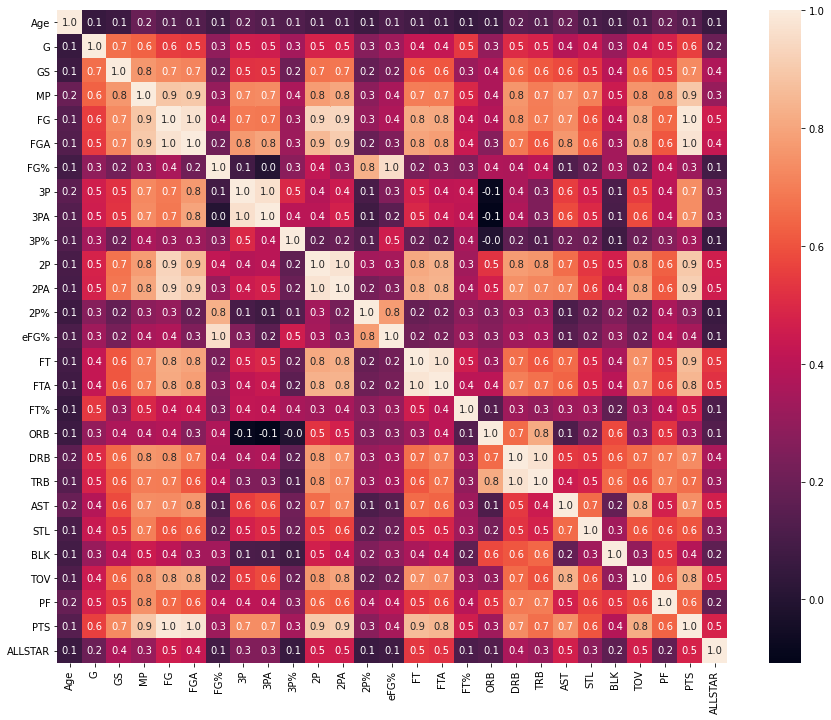

In [15]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(df.corr(), ax=ax, annot=True, fmt=".1f")

In [16]:
#sns.pairplot(df,hue="ALLSTAR")

Subsets

In [17]:
not_AS = df[df['ALLSTAR'] == 0]
a_stars = df[df['ALLSTAR'] == 1]

In [18]:
def iqr(attribute): 
    return df[attribute].quantile(0.75) - df[attribute].quantile(0.25) 

def outliers(attribute):
    iqrange = iqr(attribute)
    lower_bound = df[attribute].quantile(0.25) -(1.5 * iqrange)
    upper_bound = df[attribute].quantile(0.75) +(1.5 * iqrange)
    return df[(df[attribute] > upper_bound) | (df[attribute] < lower_bound)]

In [65]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

Age

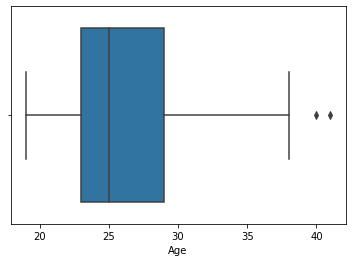

In [19]:
sns.boxplot('Age', data=df)

In [20]:
print("Number of outliers for age is: ",len(outliers('Age')))

Number of outliers for age is:  2


In [21]:
df['Age'].describe()

count    734.000000
mean      26.044959
std        4.092637
min       19.000000
25%       23.000000
50%       25.000000
75%       29.000000
max       41.000000
Name: Age, dtype: float64

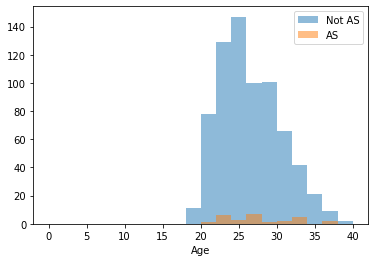

In [22]:
bins = np.arange(0, 42, 2)

plt.hist(not_AS['Age'], bins, alpha=0.5, label='Not AS')
plt.hist(a_stars['Age'], bins, alpha=0.5, label='AS')
plt.legend(loc='upper right')
plt.xlabel('Age')
plt.show()

(0.0, 45.0)

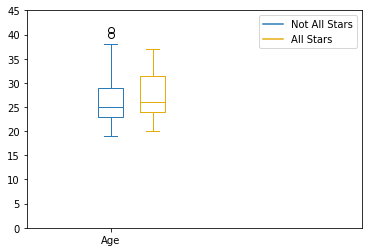

In [71]:
plt.figure()

ticks = ["Age"]

bpna = plt.boxplot(not_AS['Age'], positions=[0],widths=0.6)
bpas = plt.boxplot(a_stars['Age'], positions=[1],widths=0.6)

set_box_color(bpna, '#2C7BB6')
set_box_color(bpas, '#e6ac0e') 

plt.plot([], c='#2C7BB6', label='Not All Stars')
plt.plot([], c='#e6ac0e', label='All Stars')

plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, 6)
plt.ylim(0, 45)

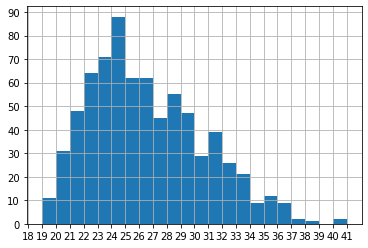

In [23]:
plt.xticks(np.arange(18, 42, 1))
plt.yticks(np.arange(0, 100, 10))
df['Age'].hist(bins=22)

In [24]:
stats.shapiro(df.Age)

ShapiroResult(statistic=0.9624007344245911, pvalue=8.798882846286493e-13)

Games

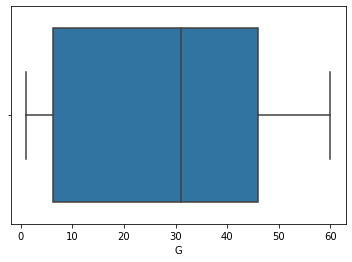

In [25]:
sns.boxplot('G', data=df)

In [26]:
print("Number of outliers for games played is: ",len(outliers('G')))

Number of outliers for games played is:  0


In [27]:
df['G'].describe()

count    734.000000
mean      28.279292
std       19.514704
min        1.000000
25%        6.250000
50%       31.000000
75%       46.000000
max       60.000000
Name: G, dtype: float64

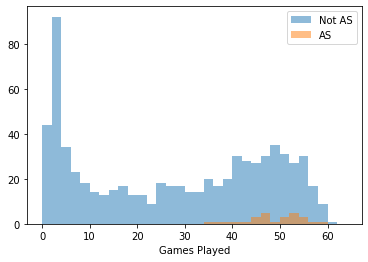

In [150]:
bins = np.arange(0, 66, 2)

plt.hist(not_AS['G'], bins, alpha=0.5, label='Not AS')
plt.hist(a_stars['G'], bins, alpha=0.5, label='AS')
plt.legend(loc='upper right')
plt.xlabel('Games Played')
plt.savefig('G-hist.png')
plt.show()

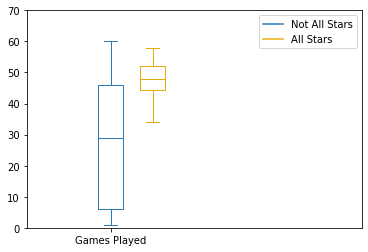

In [151]:
plt.figure()

ticks = ["Games Played"]

bpna = plt.boxplot(not_AS['G'], positions=[0],widths=0.6)
bpas = plt.boxplot(a_stars['G'], positions=[1],widths=0.6)

set_box_color(bpna, '#2C7BB6')
set_box_color(bpas, '#e6ac0e') 

plt.plot([], c='#2C7BB6', label='Not All Stars')
plt.plot([], c='#e6ac0e', label='All Stars')

plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, 6)
plt.ylim(0, 70)
plt.savefig('G-box.png')

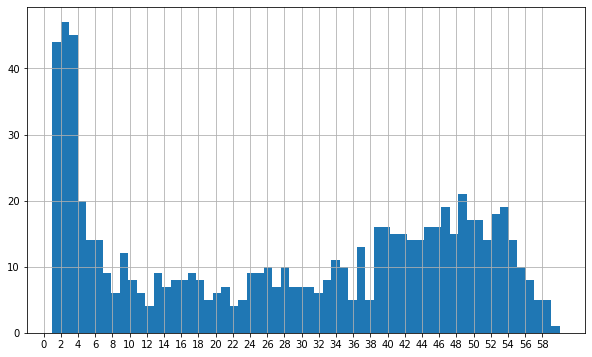

In [29]:
plt.xticks(np.arange(0, 60, 2))
plt.yticks(np.arange(0, 100, 10))
df['G'].hist(bins=60, figsize=(10, 6))

In [30]:
stats.shapiro(df.G)

ShapiroResult(statistic=0.8942295908927917, pvalue=4.815959728099254e-22)

Minutes

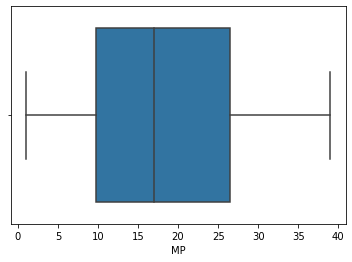

In [31]:
sns.boxplot('MP', data=df)

In [32]:
print("Number of outliers for minutes played is: ",len(outliers('MP')))

Number of outliers for minutes played is:  0


In [33]:
df['MP'].describe()

count    734.000000
mean      18.114169
std        9.995226
min        1.000000
25%        9.725000
50%       17.000000
75%       26.475000
max       39.000000
Name: MP, dtype: float64

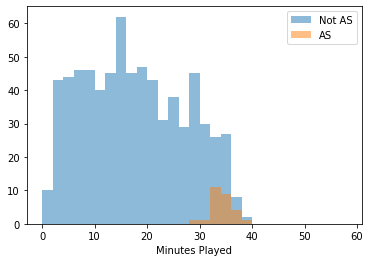

In [152]:
bins = np.arange(0, 60, 2)

plt.hist(not_AS['MP'], bins, alpha=0.5, label='Not AS')
plt.hist(a_stars['MP'], bins, alpha=0.5, label='AS')
plt.legend(loc='upper right')
plt.xlabel('Minutes Played')
plt.savefig('MP-hist.png')
plt.show()


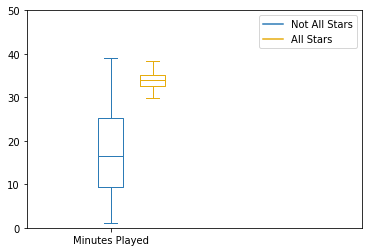

In [153]:
plt.figure()

ticks = ["Minutes Played"]

bpna = plt.boxplot(not_AS['MP'], positions=[0],widths=0.6)
bpas = plt.boxplot(a_stars['MP'], positions=[1],widths=0.6)

set_box_color(bpna, '#2C7BB6')
set_box_color(bpas, '#e6ac0e') 

plt.plot([], c='#2C7BB6', label='Not All Stars')
plt.plot([], c='#e6ac0e', label='All Stars')

plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, 6)
plt.ylim(0, 50)
plt.savefig('MP-box.png')

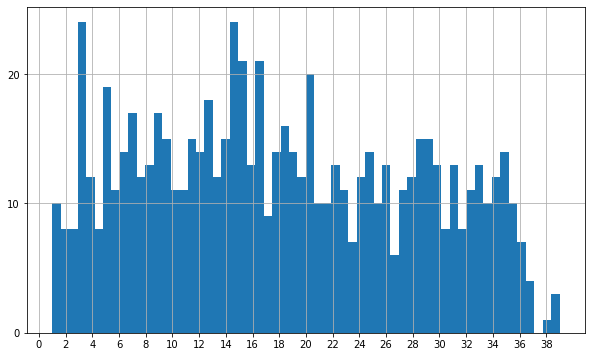

In [35]:
plt.xticks(np.arange(0, 40, 2))
plt.yticks(np.arange(0, 40, 10))
df['MP'].hist(bins=60, figsize=(10, 6))

In [36]:
stats.shapiro(df.MP)

ShapiroResult(statistic=0.9618173241615295, pvalue=6.708111713674136e-13)

Points per game

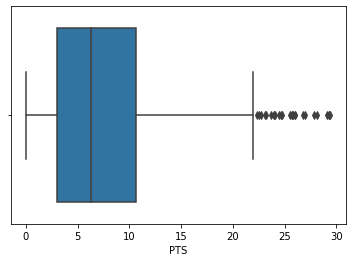

In [37]:
sns.boxplot('PTS', data=df)

In [44]:
print("Number of outliers for points scored is: ",len(outliers('PTS')))

Number of outliers for points scored is:  26


In [45]:
df['PTS'].describe()

count    734.000000
mean       7.727520
std        6.265428
min        0.000000
25%        3.000000
50%        6.300000
75%       10.675000
max       29.400000
Name: PTS, dtype: float64

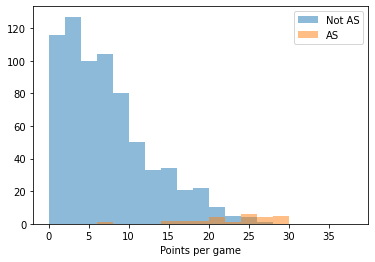

In [154]:
bins = np.arange(0, 40, 2)

plt.hist(not_AS['PTS'], bins, alpha=0.5, label='Not AS')
plt.hist(a_stars['PTS'], bins, alpha=0.5, label='AS')
plt.legend(loc='upper right')
plt.xlabel('Points per game')
plt.savefig('PTS-hist.png')
plt.show()

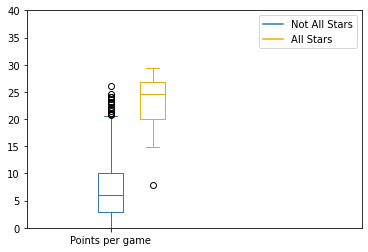

In [155]:
plt.figure()

ticks = ["Points per game"]

bpna = plt.boxplot(not_AS['PTS'], positions=[0],widths=0.6)
bpas = plt.boxplot(a_stars['PTS'], positions=[1],widths=0.6)

set_box_color(bpna, '#2C7BB6')
set_box_color(bpas, '#e6ac0e') 

plt.plot([], c='#2C7BB6', label='Not All Stars')
plt.plot([], c='#e6ac0e', label='All Stars')

plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, 6)
plt.ylim(0, 40)
plt.savefig('PTS-box.png')

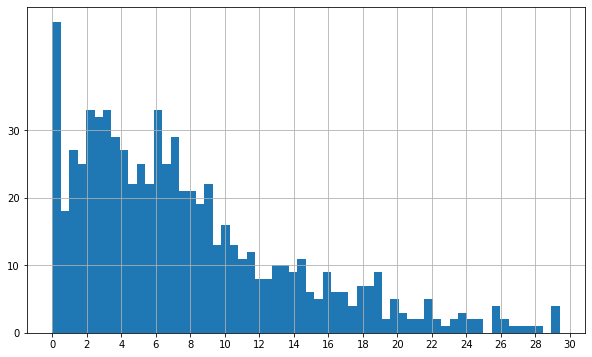

In [47]:
plt.xticks(np.arange(0, 35, 2))
plt.yticks(np.arange(0, 40, 10))
df['PTS'].hist(bins=60, figsize=(10, 6))

In [48]:
stats.shapiro(df.PTS)

ShapiroResult(statistic=0.9070057272911072, pvalue=9.656692263464443e-21)

Shooting efficiency eFG%

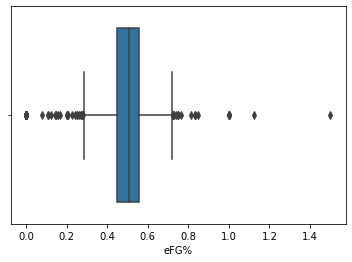

In [49]:
sns.boxplot('eFG%', data=df)

In [50]:
print("Number of outliers for shooting efficiency is: ",len(outliers('eFG%')))

Number of outliers for shooting efficiency is:  96


In [63]:
extremes = df[df['eFG%']>0.8]
extremes[['Player', 'G', 'PTS', 'eFG%']]

,Player,G,PTS,eFG%
Rk,,,,
97,Ahmad Caver,1,2.0,1.000
228,Juancho Hernangómez,2,1.5,1.500
234,Malcolm Hill,3,5.7,0.813
238,Aaron Holiday,3,7.3,0.846
278,Joe Johnson,1,2.0,1.000
335,Trey Lyles,2,2.0,1.000
353,Mac McClung,1,2.0,1.000
383,Juwan Morgan,1,5.0,0.833
434,Reggie Perry,1,2.0,1.000


In [51]:
df['eFG%'].describe()

count    734.000000
mean       0.481034
std        0.173762
min        0.000000
25%        0.449250
50%        0.508000
75%        0.558750
max        1.500000
Name: eFG%, dtype: float64

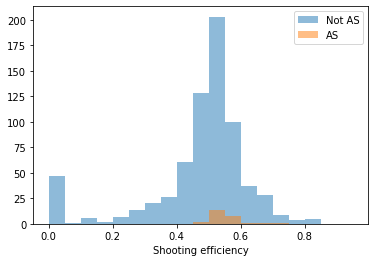

In [60]:
bins = np.arange(0.0, 1.0, 0.05)

plt.hist(not_AS['eFG%'], bins, alpha=0.5, label='Not AS')
plt.hist(a_stars['eFG%'], bins, alpha=0.5, label='AS')
plt.legend(loc='upper right')
plt.xlabel('Shooting efficiency')
plt.show()

(0.0, 1.5)

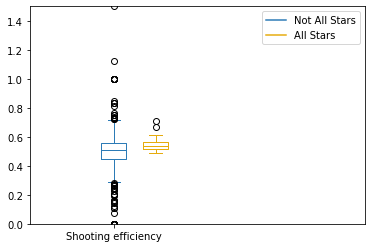

In [76]:
plt.figure()

ticks = ["Shooting efficiency"]

bpna = plt.boxplot(not_AS['eFG%'], positions=[0],widths=0.6)
bpas = plt.boxplot(a_stars['eFG%'], positions=[1],widths=0.6)

set_box_color(bpna, '#2C7BB6')
set_box_color(bpas, '#e6ac0e') 

plt.plot([], c='#2C7BB6', label='Not All Stars')
plt.plot([], c='#e6ac0e', label='All Stars')

plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, 6)
plt.ylim(0., 1.5)

Predicting Points per games

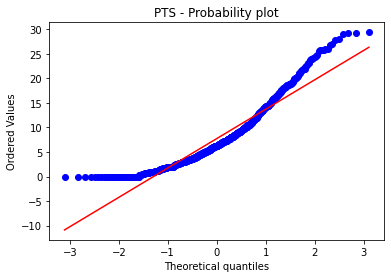

In [168]:
stats.probplot(df['PTS'], dist="norm", plot=pylab)
plt.title('PTS - Probability plot')
plt.savefig('PTS-qq.png')
pylab.show()

In [110]:
pts_shapiro = stats.shapiro(df.PTS)
tov_shapiro = stats.shapiro(df.TOV)
stl_shapiro = stats.shapiro(df.STL)
pf_shapiro = stats.shapiro(df.PF)
mp_shapiro = stats.shapiro(df.MP)
ft_shapiro = stats.shapiro(df.FT)

print("Shapiro PTS: Statistics: ", pts_shapiro.statistic , " P-values", format( pts_shapiro.pvalue, '.28f'))
print("Shapiro TOV: Statistics: ", tov_shapiro.statistic , " P-values", format( tov_shapiro.pvalue, '.28f'))
print("Shapiro STL: Statistics: ", stl_shapiro.statistic , " P-values", format( stl_shapiro.pvalue, '.28f'))
print("Shapiro PF: Statistics: ", pf_shapiro.statistic , " P-values", format( pf_shapiro.pvalue, '.28f'))
print("Shapiro MP: Statistics: ", mp_shapiro.statistic , " P-values", format( mp_shapiro.pvalue, '.28f'))
print("Shapiro FT: Statistics: ", ft_shapiro.statistic , " P-values", format( ft_shapiro.pvalue, '.28f'))


Shapiro PTS: Statistics:  0.9070057272911072  P-values 0.0000000000000000000096566923
Shapiro TOV: Statistics:  0.879149854183197  P-values 0.0000000000000000000000194843
Shapiro STL: Statistics:  0.9339361190795898  P-values 0.0000000000000000172530999517
Shapiro PF: Statistics:  0.9838533997535706  P-values 0.0000003083680439885938540101
Shapiro MP: Statistics:  0.9618173241615295  P-values 0.0000000000006708111713674136
Shapiro FT: Statistics:  0.7969810962677002  P-values 0.0000000000000000000000000000


In [120]:
def powerpuffgirls(data, method):
    power = PowerTransformer(method=method, standardize=True) 
    data_trans = power.fit_transform(data.copy())
    return data_trans

def best_transform(column,data):
    pvalues=dict()

    pvalues['data']=[stats.shapiro(data[column])[1],data]
       
    data_y=data.copy()
    data_y[column]=powerpuffgirls(data_y[[column]],"yeo-johnson")
    pvalues['data_y']=[stats.shapiro( data_y[column])[1],data_y]
    
    
    if (any(data[column]<=0)==False):
        data_b=data.copy()
        data_b[column]=powerpuffgirls(data_b[[column]],"box-cox")
        pvalues['data_b']=[stats.shapiro( data_b[column])[1],data_b]
    
    sorted_pvalues=sorted(pvalues.items(),key=operator.itemgetter(0))
    
    return(sorted_pvalues[-1][1][1])


In [121]:
col_list = ['PTS', 'AST', 'TOV', 'FT', 'MP', 'STL','PF']

for col in col_list:
  print('------------')
  print(col)
  transformed = best_transform(col, df)
  t_shapiro = stats.shapiro(transformed[col])
  print("Shapiro ", col, " : Statistics: ", t_shapiro.statistic , " P-values", format( t_shapiro.pvalue, '.28f'))
  

  


------------
PTS
Shapiro  PTS  : Statistics:  0.9869577288627625  P-values 0.0000040233203435491304844618
------------
AST
Shapiro  AST  : Statistics:  0.9748271703720093  P-values 0.0000000006337372293607757001
------------
TOV
Shapiro  TOV  : Statistics:  0.9764499664306641  P-values 0.0000000017255776807445499799
------------
FT
Shapiro  FT  : Statistics:  0.9600162506103516  P-values 0.0000000000002953196227058891
------------
MP
Shapiro  MP  : Statistics:  0.9685682058334351  P-values 0.0000000000186644050909068326
------------
STL
Shapiro  STL  : Statistics:  0.9629422426223755  P-values 0.0000000000011346997560307548
------------
PF
Shapiro  PF  : Statistics:  0.9829109907150269  P-values 0.0000001491035703793386346661


Personal fouls

Pearson correlation: 0.639


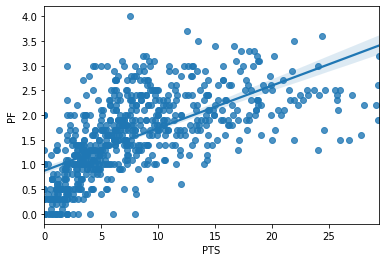

In [77]:
sns.regplot(x="PTS", y="PF", data=df)
print("Pearson correlation: %.3f" % df['PTS'].corr(df['PF']))

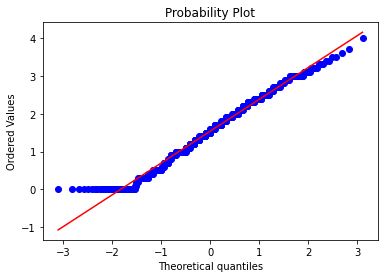

In [122]:
stats.probplot(df['PF'], dist="norm", plot=pylab)
pylab.show()

Turn overs

Pearson correlation: 0.818


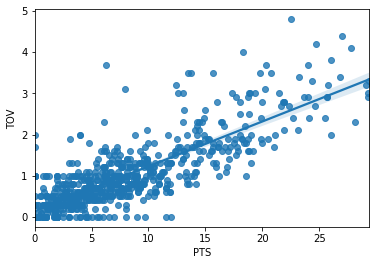

In [156]:
sns.regplot(x="PTS", y="TOV", data=df)
print("Pearson correlation: %.3f" % df['PTS'].corr(df['TOV']))
plt.savefig('PTS-TOV-corr.png')

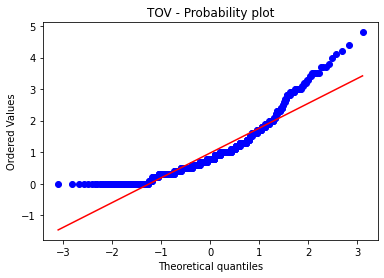

In [167]:
stats.probplot(df['TOV'], dist="norm", plot=pylab)
plt.title('TOV - Probability plot')
plt.savefig('TOV-qq.png')
pylab.show()

Pearson correlation: 0.893


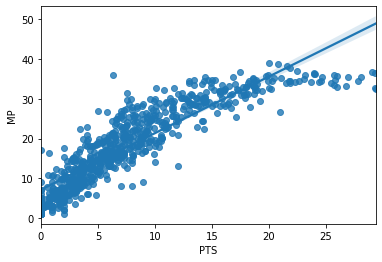

In [157]:
sns.regplot(x="PTS", y="MP", data=df)
print("Pearson correlation: %.3f" % df['PTS'].corr(df['MP']))
plt.savefig('PTS-MP-corr.png')

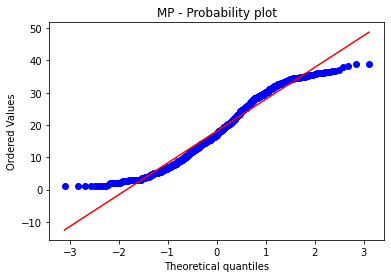

In [166]:
stats.probplot(df['MP'], dist="norm", plot=pylab)
plt.title('MP - Probability plot')
plt.savefig('MP-qq.png')
pylab.show()

Free throws made

Pearson correlation: 0.863


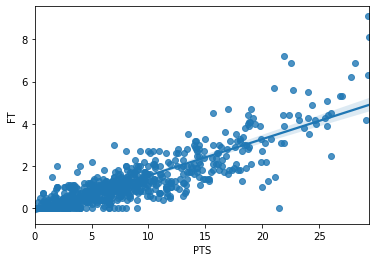

In [158]:
sns.regplot(x="PTS", y="FT", data=df)
print("Pearson correlation: %.3f" % df['PTS'].corr(df['FT']))
plt.savefig('PTS-FT-corr.png')

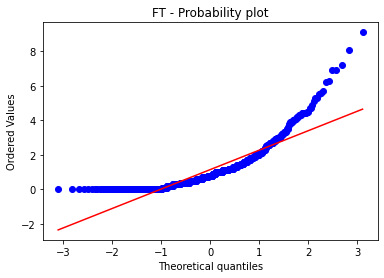

In [160]:
stats.probplot(df['FT'], dist="norm", plot=pylab)
plt.title('FT - Probability plot')
plt.savefig('FT-qq.png')
pylab.show()

Steals

Pearson correlation: 0.604


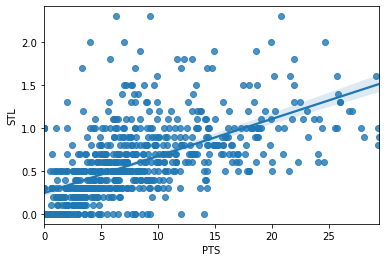

In [81]:
sns.regplot(x="PTS", y="STL", data=df)
print("Pearson correlation: %.3f" % df['PTS'].corr(df['STL']))

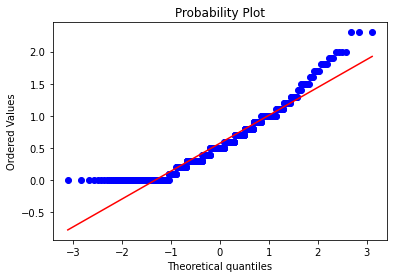

In [127]:
stats.probplot(df['STL'], dist="norm", plot=pylab)
pylab.show()

Assists

Pearson correlation: 0.745


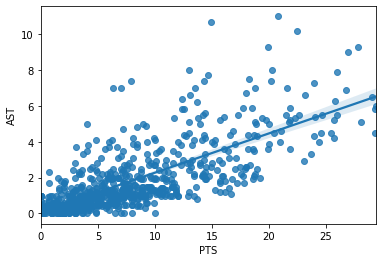

In [159]:
sns.regplot(x="PTS", y="AST", data=df)
print("Pearson correlation: %.3f" % df['PTS'].corr(df['AST']))
plt.savefig('PTS-AST-corr.png')

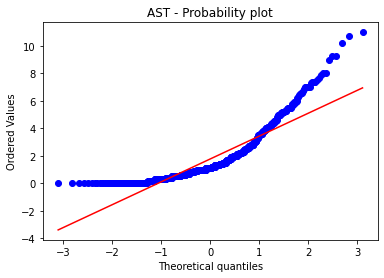

In [165]:
stats.probplot(df['AST'], dist="norm", plot=pylab)
plt.title('AST - Probability plot')
plt.savefig('AST-qq.png')
pylab.show()

In [85]:
data = df[['PTS', 'AST', 'TOV', 'FT', 'MP']]
data.head(9)

,PTS,AST,TOV,FT,MP
Rk,,,,,
1,7.5,1.1,1.0,0.9,23.1
2,7.0,3.2,1.6,1.5,26.1
3,18.7,3.5,2.9,4.4,33.0
4,3.3,0.5,0.3,0.4,10.3
5,13.7,0.8,1.0,1.7,22.8
6,12.3,2.7,1.6,1.3,25.4
6,12.8,2.8,1.7,1.4,26.3
6,0.0,0.0,0.0,0.0,2.5
7,11.5,1.5,0.6,1.0,28.0


All

In [86]:
X_train, X_test, y_train, y_test = train_test_split(data[['AST', 'TOV', 'FT', 'MP']], data['PTS'], test_size=0.2, random_state=42)

In [92]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [93]:
predictedPoints = regr.predict(X_test)

In [96]:
mean_squared_error(y_test, predictedPoints)

3.685354518078291

In [97]:
df['PTS'].describe()

count    734.000000
mean       7.727520
std        6.265428
min        0.000000
25%        3.000000
50%        6.300000
75%       10.675000
max       29.400000
Name: PTS, dtype: float64

polynomial

In [131]:
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = linear_model.LinearRegression()
pol_reg.fit(X_poly, y_train)

LinearRegression()

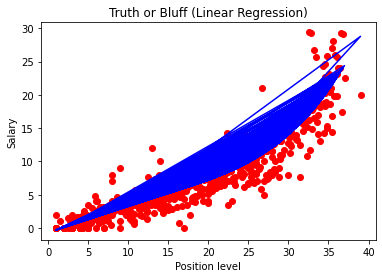

In [132]:
def viz_polymonial():
    plt.scatter(X_train, y_train, color='red')
    plt.plot(X_train, pol_reg.predict(poly_reg.fit_transform(X_train)), color='blue')
    plt.title('Truth or Bluff (Linear Regression)')
    plt.xlabel('Position level')
    plt.ylabel('Salary')
    plt.show()
    return
viz_polymonial()

Minutes

In [134]:
X_train, X_test, y_train, y_test = train_test_split(data[['MP']], data['PTS'], test_size=0.2, random_state=42)

In [135]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [136]:
predictedPoints = regr.predict(X_test)

In [137]:
mean_squared_error(y_test, predictedPoints)

9.2063425618497

In [148]:
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train)
pol_reg = linear_model.LinearRegression()
pol_reg.fit(X_poly, y_train)

LinearRegression()

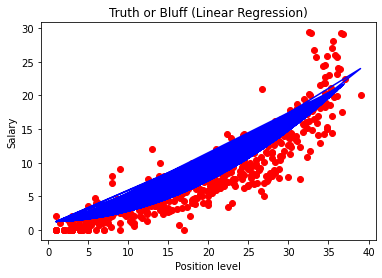

In [149]:
def viz_polymonial():
    plt.scatter(X_train, y_train, color='red')
    plt.plot(X_train, pol_reg.predict(poly_reg.fit_transform(X_train)), color='blue')
    plt.title('Truth or Bluff (Linear Regression)')
    plt.xlabel('Position level')
    plt.ylabel('Salary')
    plt.show()
    return
viz_polymonial()